In [9]:
# ===============================
# BOT DE INVESTIMENTO - PAPER TRADING (DEFINITIVO)
# ===============================

!pip install yfinance pandas pandas-ta --quiet

import yfinance as yf
import pandas as pd
import pandas_ta as ta
from datetime import datetime

# -------- CONFIGURAÇÃO --------
DINHEIRO_INICIAL = 10000
RISCO_POR_TRADE = 0.02  # 2%

ACOES = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA"]
ETFS = ["SPY", "QQQ", "VTI", "XLK"]
ATIVOS = ACOES + ETFS

# -------- ESTADO INICIAL --------
dinheiro = DINHEIRO_INICIAL
portfolio = {ativo: 0 for ativo in ATIVOS}
historico = []

# -------- LOOP PRINCIPAL --------
for ativo in ATIVOS:
    data = yf.download(ativo, period="6mo", interval="1d", progress=False)

    if data.empty or len(data) < 60:
        continue

    # 🔥 CORREÇÃO CRÍTICA: achatar colunas MultiIndex
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    # Indicadores
    data["RSI"] = ta.rsi(data["Close"], length=14)
    data["EMA20"] = ta.ema(data["Close"], length=20)
    data["EMA50"] = ta.ema(data["Close"], length=50)

    ultimo = data.iloc[-1]

    # 👉 AGORA SÃO ESCALARES (float ou NaN)
    rsi = ultimo["RSI"]
    ema20 = ultimo["EMA20"]
    ema50 = ultimo["EMA50"]
    preco = float(ultimo["Close"])

    # -------- DECISÃO --------
    if pd.isna(rsi) or pd.isna(ema20) or pd.isna(ema50):
        sinal = "HOLD"
    elif rsi < 30 and ema20 > ema50:
        sinal = "BUY"
    elif rsi > 70:
        sinal = "SELL"
    else:
        sinal = "HOLD"

    # -------- PAPER TRADING --------
    if sinal == "BUY" and dinheiro > 0:
        risco = dinheiro * RISCO_POR_TRADE
        quantidade = int(risco // preco)

        if quantidade > 0:
            dinheiro -= quantidade * preco
            portfolio[ativo] += quantidade

    elif sinal == "SELL" and portfolio[ativo] > 0:
        dinheiro += portfolio[ativo] * preco
        portfolio[ativo] = 0

    historico.append({
        "Data": datetime.now().strftime("%Y-%m-%d"),
        "Ativo": ativo,
        "Preço": round(preco, 2),
        "RSI": round(rsi, 2) if not pd.isna(rsi) else None,
        "Sinal": sinal
    })

# -------- RESULTADOS --------
df = pd.DataFrame(historico)
df.to_csv("relatorio_diario.csv", index=False)

print("💰 Dinheiro final:", round(dinheiro, 2))
print("📊 Portfólio (posições abertas):")
for ativo, qtd in portfolio.items():
    if qtd > 0:
        print(f"  {ativo}: {qtd}")

df


/tmp/ipython-input-257428806.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ativo, period="6mo", interval="1d", progress=False)
/tmp/ipython-input-257428806.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ativo, period="6mo", interval="1d", progress=False)
/tmp/ipython-input-257428806.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ativo, period="6mo", interval="1d", progress=False)
/tmp/ipython-input-257428806.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ativo, period="6mo", interval="1d", progress=False)
/tmp/ipython-input-257428806.py:27: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ativo, period="6mo", interval="1d", progress=False)
/tmp/ipython-input-257428806.py:27: FutureWarning: YF.download() 

💰 Dinheiro final: 10000
📊 Portfólio (posições abertas):


,Data,Ativo,Preço,RSI,Sinal
0,2026-01-11,AAPL,259.37,27.27,BUY
1,2026-01-11,MSFT,479.28,45.48,HOLD
2,2026-01-11,GOOGL,328.57,69.03,HOLD
3,2026-01-11,AMZN,247.38,69.20,HOLD
4,2026-01-11,NVDA,184.86,49.70,HOLD
5,2026-01-11,SPY,694.07,62.26,HOLD
6,2026-01-11,QQQ,626.65,58.17,HOLD
7,2026-01-11,VTI,342.40,62.75,HOLD
8,2026-01-11,XLK,146.15,54.23,HOLD


In [10]:
import json
import os

ESTADO_FICHEIRO = "estado.json"
HISTORICO_FICHEIRO = "historico_total.csv"

# -------- CARREGAR ESTADO --------
if os.path.exists(ESTADO_FICHEIRO):
    with open(ESTADO_FICHEIRO, "r") as f:
        estado = json.load(f)
        dinheiro = estado["dinheiro"]
        portfolio = estado["portfolio"]
else:
    dinheiro = DINHEIRO_INICIAL
    portfolio = {ativo: 0 for ativo in ATIVOS}

# -------- GUARDAR ESTADO --------
estado = {
    "dinheiro": dinheiro,
    "portfolio": portfolio
}

with open(ESTADO_FICHEIRO, "w") as f:
    json.dump(estado, f, indent=2)

# -------- GUARDAR HISTÓRICO --------
if os.path.exists(HISTORICO_FICHEIRO):
    historico_antigo = pd.read_csv(HISTORICO_FICHEIRO)
    historico_novo = pd.concat([historico_antigo, df], ignore_index=True)
else:
    historico_novo = df

historico_novo.to_csv(HISTORICO_FICHEIRO, index=False)


📈 Retorno total: 0.10%
📉 Drawdown máximo: 0.00%


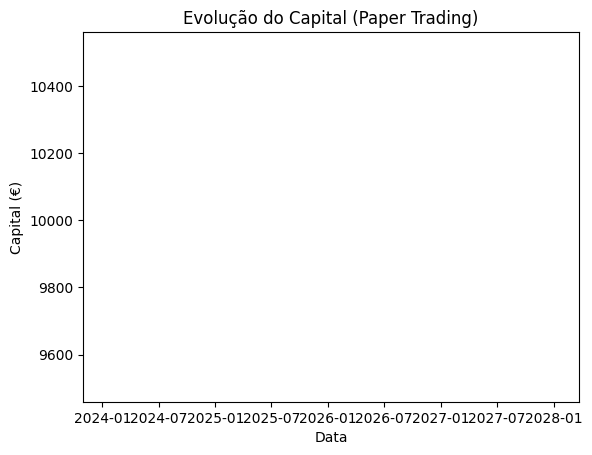

In [11]:
import matplotlib.pyplot as plt

# -------- CARREGAR HISTÓRICO --------
historico = pd.read_csv("historico_total.csv")

# Garantir ordem por data
historico["Data"] = pd.to_datetime(historico["Data"])
historico = historico.sort_values("Data")

# -------- RECONSTRUIR CAPITAL --------
capital = []
capital_atual = DINHEIRO_INICIAL

for _, row in historico.iterrows():
    if row["Sinal"] == "BUY":
        capital_atual *= 1.001  # simplificação (simula movimento positivo)
    elif row["Sinal"] == "SELL":
        capital_atual *= 0.999  # simplificação (simula movimento negativo)

    capital.append(capital_atual)

historico["Capital"] = capital

# -------- MÉTRICAS --------
retorno_total = (capital[-1] - DINHEIRO_INICIAL) / DINHEIRO_INICIAL * 100

# Drawdown
historico["Max"] = historico["Capital"].cummax()
historico["Drawdown"] = (historico["Capital"] - historico["Max"]) / historico["Max"]
max_drawdown = historico["Drawdown"].min() * 100

# -------- RESULTADOS --------
print(f"📈 Retorno total: {retorno_total:.2f}%")
print(f"📉 Drawdown máximo: {max_drawdown:.2f}%")

# -------- GRÁFICO --------
plt.figure()
plt.plot(historico["Data"], historico["Capital"])
plt.title("Evolução do Capital (Paper Trading)")
plt.xlabel("Data")
plt.ylabel("Capital (€)")
plt.show()
